In [2]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_rows', 5)
import seaborn as sns
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 7, 4
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./src/trip_data_8.csv', low_memory=False)

In [4]:
df.shape

(1261505, 14)

#### Vamos dropar os atributos desconhecidos: vendor_id e store_and_fwd_flag:

In [5]:
df.drop([' vendor_id', ' store_and_fwd_flag'], 1, inplace=True)

In [6]:
df.shape

(1261505, 12)

In [7]:
df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.261505e+06,1.261505e+06,1.261505e+06,1.261505e+06,1.261505e+06,1.261505e+06,1.261503e+06,1.261503e+06
mean,1.036542e+00,1.903010e+00,8.175101e+02,5.500859e+01,-7.320948e+01,4.032947e+01,-7.312580e+01,4.028402e+01
...,...,...,...,...,...,...,...,...
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.190000e+00,-7.396742e+01,4.076625e+01,-7.396512e+01,4.076643e+01
max,2.390000e+02,6.000000e+00,4.293410e+06,1.348017e+07,4.077343e+01,7.400605e+01,4.082298e+01,4.102000e+02


## Data Cleaning

Vamos começar buscando os nulls

In [8]:
pd.set_option('display.max_rows', 15)
df.isnull().sum()

medallion             0
 hack_license         0
 rate_code            0
 pickup_datetime      0
 dropoff_datetime     0
 passenger_count      0
 trip_time_in_secs    0
 trip_distance        0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    2
 dropoff_latitude     2
dtype: int64

In [9]:
pd.set_option('display.max_rows', 5)

In [10]:
df.ix[df[' dropoff_longitude'].isnull()]

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
328300,D1747389EAD9EB6EB0B30EE42D3B130D,AACE49C7D80767CFFEC0E513AE886DF0,0,2013-08-28 11:28:50,2013-08-28 11:28:50,0,0,0.00,-73.948677,40.744923,NaN,NaN
1261504,8D7BF8356EF4A676E1D83481A6CBF56F,609448857F72EDAE9BC6ED98970D4A41,1,2013-08-13 11:48:00,2013-08-13 12:12:00,5,1440,2.31,-73.982964,40.774250,NaN,NaN


In [11]:
df = df.ix[df[' dropoff_longitude'].notnull()].reset_index(drop=True)

In [12]:
len(df)

1261503

### Como estamos analisando mobilidade em NY, não faz sentido manter as linhas em que a distância ou o tempo de viagem sejam 0. Sei que para alguns estudos essa informação pode ser útil, mas para o nosso caso em específico, não faz sentido

Temos alguns tempos negativos também, então vamos limpá-los juntos

In [13]:
len(df.ix[df[' trip_time_in_secs']<=0])

5228

São 5228 linhas que não posso fazer muita coisa pois não tenho como inferir o tempo, então vou remover do df para não ter problemas futuros

In [14]:
df = df.ix[df[' trip_time_in_secs']>0].reset_index(drop=True)

Agora farei o mesmo para distâncias <= 0

In [15]:
len(df)

1256275

In [16]:
df = df.ix[df[' trip_distance']>0].reset_index(drop=True)

Voltando ao trip time. Vamos olhar outliers

In [17]:
df[' trip_time_in_secs'].sort_values(ascending=False)

43073     4293410
177598    4293042
           ...   
360137          1
223588          1
Name:  trip_time_in_secs, dtype: int64

Nós temos alguns tempos realmente longos e que parecem erros da base. Utilizar a fórmula padrão que diz que um outlier é um valor maior que o 3º quartil + 1.5*IQR não funciona pois temos algumas viagens que se descolam muito da mediana por terem distâncias longas.

In [18]:
import numpy as np

In [19]:
iqr = np.subtract(*np.percentile(df[' trip_time_in_secs'], [75, 25]))

In [20]:
ThirdQuartile = np.percentile(df[' trip_time_in_secs'], 75)

In [21]:
len(df.ix[df[' trip_time_in_secs']>(ThirdQuartile+(1.5*iqr))].sort(columns=' trip_time_in_secs', ascending=True))

55445

Vamos remover os outliers aos poucos. Tempos com mais de 5 dígitos são claramente erros, então vamos removê-los

In [22]:
df = df.drop(df[(df[' trip_time_in_secs']>99999)].index).reset_index(drop=True)

#### Vamos começar analisando o rate_code, para ver se todos são válidos, segundo o: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

In [23]:
pd.set_option('display.max_rows', 12)
df[' rate_code'].value_counts()

1      1223279
2        23616
3         1989
5         1685
4          611
0           30
6            9
200          1
Name:  rate_code, dtype: int64

#### Como pode ser visto acima, alguns valores do rate_code não são válidos. Esses valores são: 200 e 0 . O número de ocorrências é bem pequeno comparado ao tamanho total da amostra de dados. Por este motivo e pela falta de tempo, não criarei uma função que utilizaria o geopy para identificar o ponto de saída e chegada, além da hora para classificar a tarifa corretamente. Neste momento eu vou simplesmente descartar essas linhas

In [24]:
pd.set_option('display.max_rows', 8)

In [25]:
df = df.ix[df[' rate_code'].isin([1,2,3,4,5,6]),:].reset_index(drop=True)

In [26]:
df.shape

(1251189, 12)

In [27]:
print('Mediana: ' + str(df[' trip_distance'].median()) + ' \nMédia: '+ str(df[' trip_distance'].mean()))

Mediana: 1.76 
Média: 55.46085939854595


Como podemos ver acima a mediana se descola muito da média, que é bem maior, mostrando que nós temos alguns outliers nas distâncias. Por este motivo, vamos olhar um pouco melhor essas grandes distâncias. 

In [28]:
df.sort(columns=' trip_distance', ascending=False).head(8)

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
329560,3DCFC9097488D3F93982ED4A899C6E24,0B21B07994F53C937E2687A81488A3C5,1,2013-08-26 06:31:35,2013-08-26 06:44:00,1,745,13480170.0,-73.980377,40.732262,-74.011780,40.715099
329493,A6FEF39DB6A3DE3893DAABB98E46C8DC,D5EDBD218A9831DE3ECC458B8E2DC608,1,2013-08-31 16:15:32,2013-08-31 16:48:48,2,1996,12000000.0,-73.982048,40.780254,-73.994362,40.761311
362481,A6FEF39DB6A3DE3893DAABB98E46C8DC,D71585382E18358678091C2B98C548F0,1,2013-08-30 14:23:01,2013-08-30 14:38:28,1,927,11800001.0,-74.004601,40.706852,-73.974815,40.749310
164693,A9236AB56BD652C8450897CECC80C433,BC0B2E4616DF627759FA42A90A2CAD97,1,2013-08-26 03:30:41,2013-08-26 03:49:23,1,1121,8000014.5,-74.007790,40.741314,-73.945755,40.725468
359388,3DCFC9097488D3F93982ED4A899C6E24,0B21B07994F53C937E2687A81488A3C5,1,2013-08-27 12:23:52,2013-08-27 12:36:45,4,773,8000000.5,-73.980103,40.746334,-73.968636,40.754169
318895,A6FEF39DB6A3DE3893DAABB98E46C8DC,D5EDBD218A9831DE3ECC458B8E2DC608,1,2013-08-31 14:28:46,2013-08-31 16:14:07,3,1322,6747240.0,-73.991661,40.757942,-73.981613,40.781246
29414,EB549FD037CCC77B2744A49AACC2400F,E40656BFCF190E7BF1CE7C173325B172,1,2013-08-27 23:29:38,2013-08-27 23:52:32,2,1373,5005073.0,-73.960594,40.715412,-74.007011,40.741390
60003,EB549FD037CCC77B2744A49AACC2400F,EF53988270E9AC1A8B4AE4047B40456E,1,2013-08-31 12:15:20,2013-08-31 12:27:25,1,725,318000.0,-73.992714,40.747520,-73.959213,40.769131


Sabemos que Velocidade=Distancia/tempo. A primeira observação acima nos dá uma velocidade de mais de 18k milhas/s. Nova York tem limites de 30mp/h nas ruas e 65mp/h nas estradas. Vamos achar e descartar os veículos que tiveram velocidade média acima de 100mp/h. Essas observações tem grandes chances de terem problemas no tempo, na distância ou em ambos

In [29]:
df.ix[(df[' trip_distance']/(df[' trip_time_in_secs']/3600))>100]

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
676,8A6F61BD5F45066A5773A2AF58E113FF,7D35FAFCC77E7BE262098A6E960EDBA4,1,2013-08-27 12:27:02,2013-08-27 12:27:06,1,3,0.30,-73.996048,40.728649,-73.996536,40.728897
1075,A6086D46B46031992FE603D412D80F8E,0ADC15AAD39FA90CDFA958C79CD0FD33,1,2013-08-28 05:45:52,2013-08-28 05:46:21,1,28,0.80,-73.993149,40.749584,-73.994011,40.750130
1546,BCF3D4EBB257C316FA4B375A0A92FA0F,C6ECAC6C384169EDFE0E5F1E298E3F8A,1,2013-08-27 09:59:29,2013-08-27 09:59:32,1,2,0.50,-73.970284,40.806435,-73.970619,40.806004
4246,11AD539AEC155D68644C384188F4D961,BC01267D1B02FA153ADAE031BC9A605D,1,2013-08-28 20:29:15,2013-08-28 20:29:43,1,28,2.00,-73.987541,40.738194,-73.988174,40.738026
...,...,...,...,...,...,...,...,...,...,...,...,...
540655,02D98AA3CB447475FD0F3BA4C9D68BEB,2DD32B8EF147BB66D1EA431D25872781,2,2013-08-11 18:54:00,2013-08-11 18:56:00,1,120,4.16,-73.925339,40.735992,-73.952271,40.741535
778431,3E86DAAE0EC6469792192248417D8450,7803E14A65B3C3F98EF72111ABE949C0,2,2013-08-08 07:36:00,2013-08-08 07:47:00,1,660,20.22,-73.973312,40.760227,-73.945107,40.782944
1138478,588B9D6CE34BDF9E4E2536263E528B47,021258673DAF30F720DA79A71479957B,2,2013-08-12 20:40:00,2013-08-12 20:48:00,1,480,18.60,-73.941872,40.739601,-73.973984,40.754875
1244413,48A106A9E7294473EEF9C7C2259771FE,A33159AEDC12548035125F2C077B7102,1,2013-08-13 16:12:00,2013-08-13 16:16:00,1,240,11.48,-73.940079,40.750729,-73.962860,40.760567


In [30]:
df = df.drop(df[(df[' trip_distance']/(df[' trip_time_in_secs']/3600))>100].index).reset_index(drop=True)

In [31]:
print('Mediana: ' + str(df[' trip_distance'].median()) + ' \nMédia: '+ str(df[' trip_distance'].mean()))

Mediana: 1.76 
Média: 2.9540091582618686


Agora nossa média está bem mais próxima da mediana e faz mais sentido

## Início da Análise

In [32]:
#Função para plottar gráficos de distribuição de forma simplificada. Este modelo de função suporta apenas um filtro por vez.
def print_distribution(ax,dataframe,filter_column,filter_value, column_to_display, title,ylabel, xlabel,legend='', bins=None ):
    sns.distplot(dataframe.ix[df[filter_column]==filter_value,column_to_display],bins, ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if len(legend)>0:
        ax.set_legend(legend)    

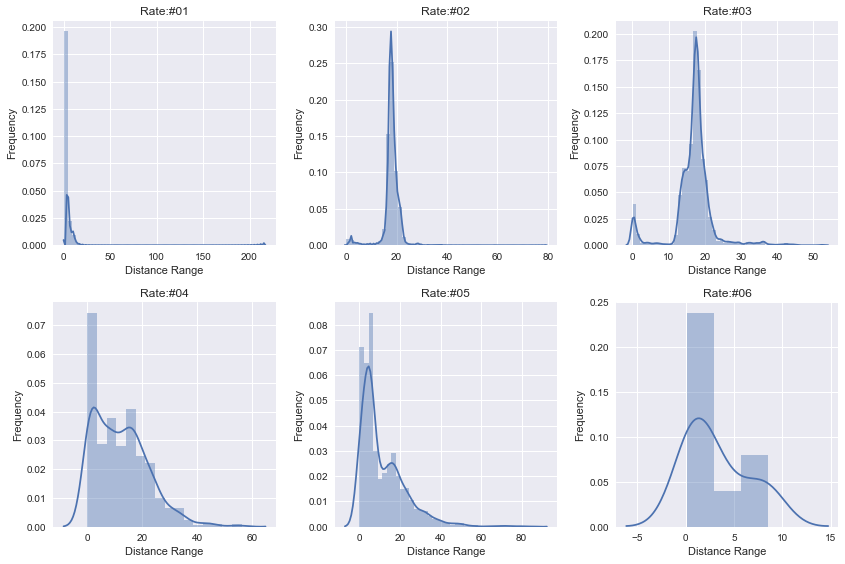

In [33]:
plt.rcParams['figure.figsize'] = 12,8
fig, ax = plt.subplots(nrows=2, ncols=3)
z=1
for x in range(2):
    for y in range(3):
        plt.tight_layout()
        print_distribution(ax[x,y], df,' rate_code',z,' trip_distance', 'Rate:#0'+str(z), 'Frequency', 'Distance Range')
        z+=1  

In [34]:
plt.rcParams['figure.figsize'] = 7, 4

Vamos olhar as distâncias médias agora:

In [35]:
for i in range(1,7):
    print('Distância Média com tarifa #' + str(i) +': ' +str(round(df.ix[df[' rate_code']==i, ' trip_distance'].mean(),2))+ ' milhas')

Distância Média com tarifa #1: 2.63 milhas
Distância Média com tarifa #2: 17.77 milhas
Distância Média com tarifa #3: 16.87 milhas
Distância Média com tarifa #4: 12.22 milhas
Distância Média com tarifa #5: 11.56 milhas
Distância Média com tarifa #6: 3.23 milhas


Vemos que as tarifas 2 e 3, que são as tarifas com origem ou destino em aeroportos são as que possuem as maiores distâncias médias, superando inclusive as tarifas 4 e 5 que são referentes a corridas fora da cidade. As tarifas 1 e 3 são usadas normalmente para corridas curtas. A 6 se refere a corridas em grupo.

#### Agora vamos dar uma olhada no tempo médio de viagem

In [36]:
for i in range(1,7):
    print('Tempo médio com tarifa #' + str(i) +': ' +str(round(df.ix[df[' rate_code']==i, ' trip_time_in_secs'].mean()/60,2))+ ' minutos')

Tempo médio com tarifa #1: 11.85 minutos
Tempo médio com tarifa #2: 40.92 minutos
Tempo médio com tarifa #3: 36.07 minutos
Tempo médio com tarifa #4: 25.02 minutos
Tempo médio com tarifa #5: 28.0 minutos
Tempo médio com tarifa #6: 25.85 minutos


Vamos ver agora como é a distribuição de corridas entre as diferentes taxas:

1    1222897
2      23581
3       1967
5       1613
4        607
6          9
Name:  rate_code, dtype: int64


''

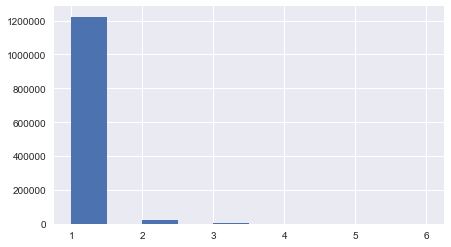

In [37]:
#Vou printar os valores antes do histograma para evidenciar a diferença entre as concentrações
print(df[' rate_code'].value_counts())
plt.hist(df[' rate_code'])
''

#### Aqui fica claro que a rate 1 tem concentração muito mais alta do que as outras

In [38]:
df[' pickup_datetime'].min()

'2013-08-05 00:19:00'

In [39]:
df[' pickup_datetime'].max()

'2013-08-31 23:59:59'

In [40]:
df[' dropoff_datetime'].min()

'2013-08-05 00:26:00'

In [41]:
df[' dropoff_datetime'].max()

'2013-09-01 00:52:00'

Todas as datas de embarque estão em Agosto de 2013, mas temos desembarque em Setembro. Para facilitar a análise, criarei colunas com mês, dia, hora e minuto tanto para embarque como para desembarque

In [42]:
df['pickup_month'] = df[' pickup_datetime'].str.slice(start=5, stop=7)
df['pickup_day'] = df[' pickup_datetime'].str.slice(start=8, stop=10)
df['pickup_hour'] = df[' pickup_datetime'].str.slice(start=11, stop=13)
df['pickup_minute'] = df[' pickup_datetime'].str.slice(start=14, stop=16)

In [43]:
df['dropoff_month'] = df[' dropoff_datetime'].str.slice(start=5, stop=7)
df['dropoff_day'] = df[' dropoff_datetime'].str.slice(start=8, stop=10)
df['dropoff_hour'] = df[' dropoff_datetime'].str.slice(start=11, stop=13)
df['dropoff_minute'] = df[' dropoff_datetime'].str.slice(start=14, stop=16)

In [44]:
df.columns

Index(['medallion', ' hack_license', ' rate_code', ' pickup_datetime',
       ' dropoff_datetime', ' passenger_count', ' trip_time_in_secs',
       ' trip_distance', ' pickup_longitude', ' pickup_latitude',
       ' dropoff_longitude', ' dropoff_latitude', 'pickup_month', 'pickup_day',
       'pickup_hour', 'pickup_minute', 'dropoff_month', 'dropoff_day',
       'dropoff_hour', 'dropoff_minute'],
      dtype='object')

In [45]:
df['speed_mph'] = df[' trip_distance']/(df[' trip_time_in_secs']/3600)

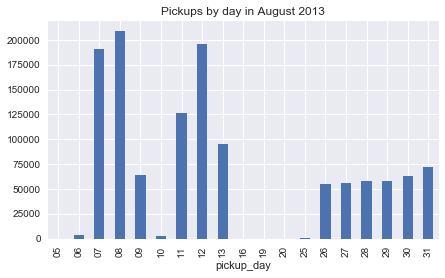

In [46]:
df.groupby(by=['pickup_day'])[' hack_license'].count().plot(kind='bar', title='Pickups by day in August 2013')

#### Claramente nós temos dias faltantes nos embarques, o que inviabiliza uma análise por dia do mês em Agosto

Mas vamos tentar uma análise por hora

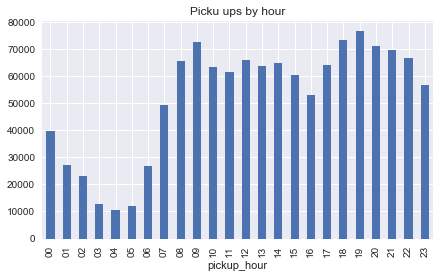

In [47]:
df.groupby(by=['pickup_hour'])[' hack_license'].count().plot(kind='bar', title='Picku ups by hour')

#### Ignorando o dia do mês e considerando apenas a hora, vemos uma curva que indica picos as 9h e às 19h, podendo significar a população indo e voltando do trabalho. Temos uma baixa na demanda, durante a madrugada.

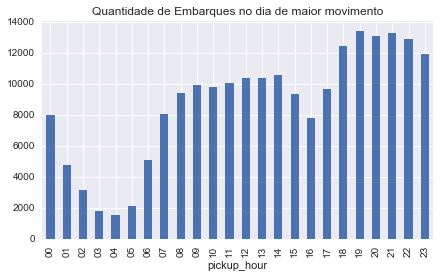

In [48]:
df.ix[df['pickup_day']=='08',:].groupby(by=['pickup_hour'])[' hack_license'].count().plot(kind='bar', title='Quantidade de Embarques no dia de maior movimento')

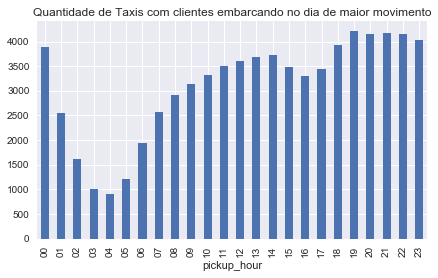

In [49]:
df.ix[df['pickup_day']=='08',:].groupby(by=['pickup_hour'])[' hack_license'].nunique().plot(kind='bar', title='Quantidade de Taxis com clientes embarcando no dia de maior movimento')

Agora vamos analisar o comportamento da velocidade em cada rate 

In [50]:
df["new_pickup_date"] = pd.to_datetime(df[" pickup_datetime"])

In [51]:
df['weekday'] = df['new_pickup_date'].dt.weekday

FDS = 5,6

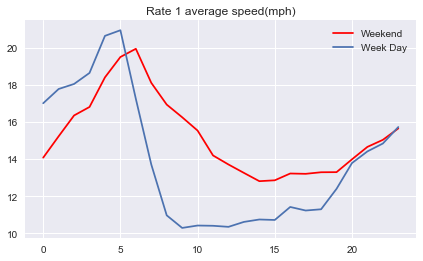

In [52]:
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==1) & (~df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Week day')
plt.legend(['Weekend', 'Week Day'])
plt.title('Rate 1 average speed(mph)')

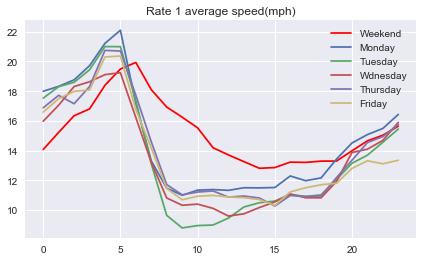

In [53]:
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([0])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([1])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([2])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([3])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([4])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 1 average speed(mph)')

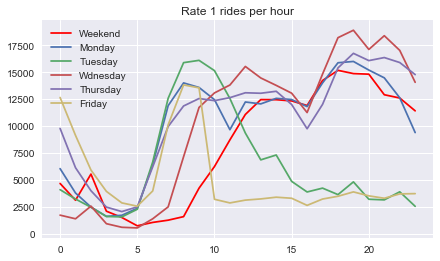

In [54]:
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([5,6])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([0])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([1])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([2])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([3])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==1) & (df['weekday'].isin([4])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 1 rides per hour')

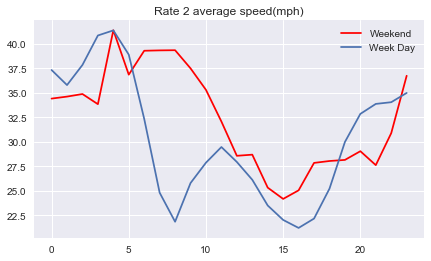

In [55]:
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==2) & (~df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Week day')
plt.legend(['Weekend', 'Week Day'])
plt.title('Rate 2 average speed(mph)')

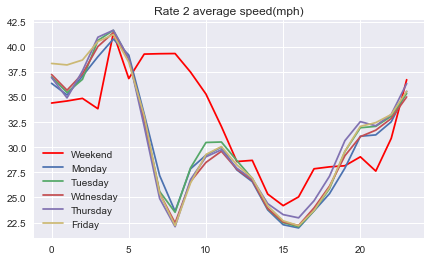

In [56]:
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==2) & (~df['weekday'].isin([0])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==2) & (~df['weekday'].isin([1])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==2) & (~df['weekday'].isin([2])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==2) & (~df['weekday'].isin([3])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==2) & (~df['weekday'].isin([4])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 2 average speed(mph)')

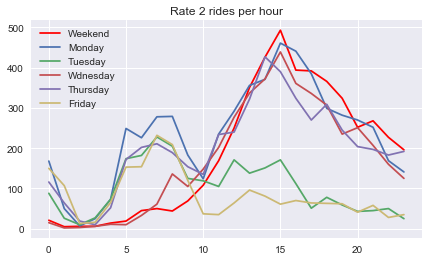

In [57]:
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([5,6])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([0])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([1])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([2])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([3])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==2) & (df['weekday'].isin([4])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 2 rides per hour')

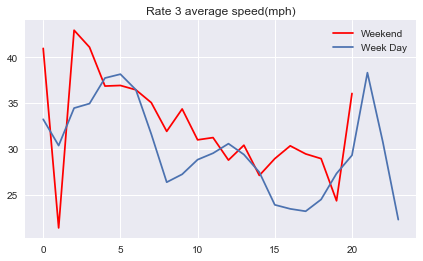

In [58]:
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==3) & (~df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Week day')
plt.legend(['Weekend', 'Week Day'])
plt.title('Rate 3 average speed(mph)')

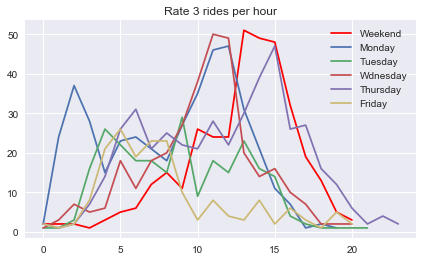

In [59]:
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([5,6])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([0])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([1])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([2])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([3])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==3) & (df['weekday'].isin([4])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 3 rides per hour')

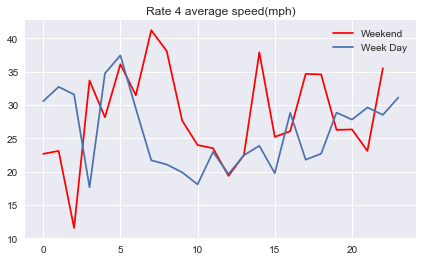

In [60]:
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==4) & (~df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Week day')
plt.legend(['Weekend', 'Week Day'])
plt.title('Rate 4 average speed(mph)')

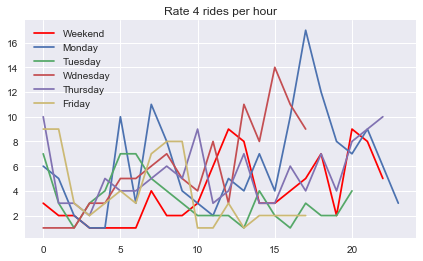

In [61]:
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([5,6])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([0])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([1])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([2])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([3])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==4) & (df['weekday'].isin([4])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 4 rides per hour')

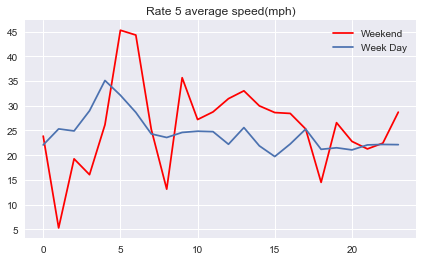

In [62]:
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==5) & (~df['weekday'].isin([5,6])), ['pickup_hour', 'speed_mph']].groupby('pickup_hour').mean().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Week day')
plt.legend(['Weekend', 'Week Day'])
plt.title('Rate 5 average speed(mph)')

Como vemos nos gráficos, a velocidade durante a semana costuma ser bem menor do que aos finais de semana.

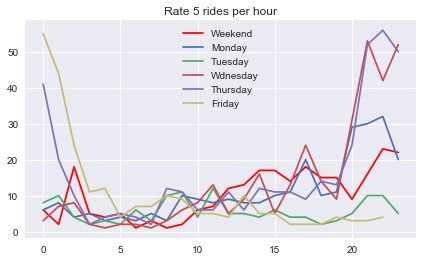

In [63]:
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([5,6])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Weekend', color='r')
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([0])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Monday')
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([1])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Tuesday')
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([2])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Wednesday')
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([3])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Thursday')
plt.plot(df.ix[(df[' rate_code']==5) & (df['weekday'].isin([4])), ['pickup_hour', ' hack_license']].groupby('pickup_hour').size().reset_index().sort_values(by='pickup_hour').drop('pickup_hour',1), label='Friday')
plt.legend(['Weekend', 'Monday', 'Tuesday', 'Wdnesday', 'Thursday', 'Friday'])
plt.title('Rate 5 rides per hour')

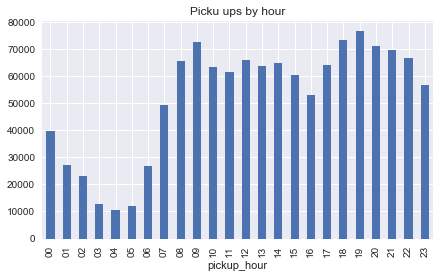

In [64]:
df.groupby(by=['pickup_hour'])[' hack_license'].count().plot(kind='bar', title='Picku ups by hour')

In [65]:
len(df[' hack_license'].unique())

26255

In [66]:
df.ix[(df['weekday'].isin([5,6])), [' hack_license']].groupby(by=' hack_license').size().sort_values(ascending=False)

 hack_license
08026D69508127F4DE855678ABCE7E0A    52
2AB7078A2A8C9D9171D930889901FE9B    48
94869BBB34DE9A727BF86D8339D3571E    48
8BF0E72CAB26DAC5F1BC7E052DC7CF63    48
                                    ..
A2A10669EB5115B8C1AA49C886A33C24     1
A2C276DAE9F05ADC225177AB7D2C1A17     1
A3746ED4A8FE7BEEDC352898F19FFA99     1
0002555BBE359440D6CEB34B699D3932     1
dtype: int64

In [67]:
df.ix[(~df['weekday'].isin([5,6])), [' hack_license']].groupby(by=' hack_license').size().sort_values(ascending=False)

 hack_license
D85749E8852FCC66A990E40605607B2F    183
AE80F081370C4CF37E54A7C362395DF7    177
51C1BE97280A80EBFA8DAD34E1956CF6    174
0B7FAC090C0A5BF9574FCE5A827D7261    167
                                   ... 
6B1BDBD97E2C6E41A1F085DB803474B0      1
CF89755E97C11B8120CD6208EE6729E6      1
577DAD2205EF50481E751B0B65B7454C      1
BAC146F5AA74DE3040A5D53572EA663A      1
dtype: int64

In [68]:
df.groupby(by=' hack_license').agg({'medallion':'count', ' trip_distance':'mean'}).reset_index().sort_values(by='medallion', ascending=False)

,hack_license,medallion,trip_distance
22207,D85749E8852FCC66A990E40605607B2F,218,3.122752
8315,51C1BE97280A80EBFA8DAD34E1956CF6,217,2.430507
1585,0F8BE7E256CFA7F732B365ABCAF3921F,195,2.128308
9903,60DF127B89DFEC0FB7948F18A0CC6D9D,194,2.515567
...,...,...,...
9651,5E08997C797FD0437E12E92F2DA57620,1,0.400000
9518,5CC0B29423769DFC049376F01AF033C9,1,13.090000
9459,5C43F805400C1B97E8F8139B3256FC36,1,1.500000
0,0002555BBE359440D6CEB34B699D3932,1,5.900000


In [69]:
pd.set_option('display.max_rows', 15)

In [70]:
df.groupby(by=' hack_license').agg({'medallion':'count', ' trip_distance':'mean'}).reset_index().sort_values(by='medallion', ascending=False)

,hack_license,medallion,trip_distance
22207,D85749E8852FCC66A990E40605607B2F,218,3.122752
8315,51C1BE97280A80EBFA8DAD34E1956CF6,217,2.430507
1585,0F8BE7E256CFA7F732B365ABCAF3921F,195,2.128308
9903,60DF127B89DFEC0FB7948F18A0CC6D9D,194,2.515567
16158,9E035DBF346FDE01FE87FAB470276DA6,191,1.884450
8790,563219AB6E23D89FA47175E39EDC1DDF,180,2.542111
6994,44F3FA98ECDE0CB68787B2A8C2BAE4D0,180,2.275611
...,...,...,...
9825,600DC0186CDB2DEC111DFAB8A9159F91,1,0.700000
9813,5FE5A12C8614556DC3CFB76A429ECA7F,1,0.300000


In [71]:
df.ix[df[' hack_license']=='7B19DE6D4D54999531BEB27F758F71F6']

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,...,pickup_day,pickup_hour,pickup_minute,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,speed_mph,new_pickup_date,weekday
433813,D2A8E7A2894575F988F336AC54300925,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-11 13:25:00,2013-08-11 13:29:00,1,240,0.02,0.000000,0.000000,...,11,13,25,08,11,13,29,0.300000,2013-08-11 13:25:00,6
1033108,97CA4DA02FA5ADC0EC4E89ECF974514B,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-12 11:21:00,2013-08-12 13:08:00,1,6420,0.02,0.000000,0.000000,...,12,11,21,08,12,13,08,0.011215,2013-08-12 11:21:00,0
1075096,E1D18D4E8BFD7A4E3647B3B1A22D64E8,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-12 19:01:00,2013-08-12 19:03:00,1,120,0.05,-73.937454,40.758259,...,12,19,01,08,12,19,03,1.500000,2013-08-12 19:01:00,0
1152523,E1D18D4E8BFD7A4E3647B3B1A22D64E8,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-12 18:45:00,2013-08-12 18:46:00,1,60,0.03,-73.937393,40.758163,...,12,18,45,08,12,18,46,1.800000,2013-08-12 18:45:00,0


In [72]:
df.ix[(df[' pickup_latitude']==0) & (df[' pickup_longitude']!=0)]

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,...,pickup_day,pickup_hour,pickup_minute,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,speed_mph,new_pickup_date,weekday
608449,8D1BB91A5D5D7BE4BEDFF23F2DEFD026,4AF51CFB6625EF4B2F3D28F887831D0C,1,2013-08-06 20:59:00,2013-08-06 21:21:00,5,1320,6.09,-73.986565,0.0,...,06,20,59,08,06,21,21,16.609091,2013-08-06 20:59:00,1
716426,566284B58F01B2795826A1EB2D3F0878,923F7DB16E1F81101C4C45A5918A2A2F,1,2013-08-08 09:21:00,2013-08-08 09:30:00,1,540,1.60,-73.966789,0.0,...,08,09,21,08,08,09,30,10.666667,2013-08-08 09:21:00,3
749309,4EF7FFB140F99C849410B914939B4949,6826C6F899BC8E147099C30C1BAA9B8F,1,2013-08-08 12:50:00,2013-08-08 13:07:00,6,1020,7.16,-5.576667,0.0,...,08,12,50,08,08,13,07,25.270588,2013-08-08 12:50:00,3
903137,8C888A90058235542F37DFB4E8232E8A,DED82821229975847692EAD33528A8F1,1,2013-08-09 00:32:00,2013-08-09 00:45:00,1,780,3.20,-0.030000,0.0,...,09,00,32,08,09,00,45,14.769231,2013-08-09 00:32:00,4
1168228,8C888A90058235542F37DFB4E8232E8A,DED82821229975847692EAD33528A8F1,1,2013-08-13 02:28:00,2013-08-13 02:41:00,1,780,5.11,-0.001667,0.0,...,13,02,28,08,13,02,41,23.584615,2013-08-13 02:28:00,1


In [1]:
import folium

In [79]:
map_ny = folium.Map(location=[40.730610, -73.935242], zoom_start=10.5)
map_ny.save('ny.html')

In [ ]:
folium.Marker([45.3288, -121.6625], popup='Mt. Hood Meadows').add_to(map_1)

In [84]:
for i in range (100):
    folium.Marker([df[' pickup_latitude'][i], df[' pickup_longitude'][i]], popup='Pickup point').add_to(map_ny)

In [85]:
map_ny

In [1]:
import osmnx as ox, networkx as nx
from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)

In [2]:
G = ox.graph_from_place('New York, New York, USA', network_type='drive')

In [6]:
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [ ]:
filepath = 'data/nyc.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [ ]:
ox.plot_route_folium()

In [80]:
state_geo = r'data/lion.json'

In [82]:
map_ny.choropleth(geo_path=state_geo, data=state_data,
             columns=['State', 'Unemployment'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment Rate (%)')

'data/lion.json'